In [1]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 61.0 MB/s eta 0:00:00:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=3715266d29631127a4ab9c57f4c68b6abb421af87f82625c8afa0f5bcd30cbab
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=630aee6edc584a9d8eaf3307a908dbb0cedd2802d2e710c8614e20942d9782f9
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-p

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
import os
import gc 
import cv2
import random

from tqdm.auto import tqdm
import torch.nn.functional as F
from tensorflow.keras.preprocessing.image import load_img
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter

In [3]:
# def seed_everything(seed=100):
#     random.seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False
# seed_everything()

In [4]:
# Select the device to train on
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
EPOCHS = 100
LR = 1e-4    
IMG_SIZE = 192
BATCH_SIZE = 16

In [5]:
images=os.listdir("/kaggle/input/cleaned-nr206/Cleaned_DataSet/Train")
masks=os.listdir("/kaggle/input/cleaned-nr206/Cleaned_DataSet/train_labels")
train_df=pd.DataFrame({"images":map(lambda x:os.path.join("/kaggle/input/cleaned-nr206/Cleaned_DataSet/Train",x),images),"masks":map(lambda x:os.path.join("/kaggle/input/cleaned-nr206/Cleaned_DataSet/train_labels",x),masks)})
print(train_df.shape)
del images, masks
train_df.head()

(126, 2)


,images,masks
0,/kaggle/input/cleaned-nr206/Cleaned_DataSet/Tr...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/tr...
1,/kaggle/input/cleaned-nr206/Cleaned_DataSet/Tr...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/tr...
2,/kaggle/input/cleaned-nr206/Cleaned_DataSet/Tr...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/tr...
3,/kaggle/input/cleaned-nr206/Cleaned_DataSet/Tr...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/tr...
4,/kaggle/input/cleaned-nr206/Cleaned_DataSet/Tr...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/tr...


In [6]:
images=os.listdir("/kaggle/input/cleaned-nr206/Cleaned_DataSet/val")
masks=os.listdir("/kaggle/input/cleaned-nr206/Cleaned_DataSet/val_labels")
val_df=pd.DataFrame({"images":map(lambda x:os.path.join("/kaggle/input/cleaned-nr206/Cleaned_DataSet/val",x),images),"masks":map(lambda x:os.path.join("/kaggle/input/cleaned-nr206/Cleaned_DataSet/val_labels",x),masks)})
print(val_df.shape)
del images, masks
val_df.head()

(40, 2)


,images,masks
0,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...
1,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...
2,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...
3,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...
4,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...


In [7]:
images=os.listdir("/kaggle/input/cleaned-nr206/Cleaned_DataSet/test")
masks=os.listdir("/kaggle/input/cleaned-nr206/Cleaned_DataSet/test_labels")
test_df=pd.DataFrame({"images":map(lambda x:os.path.join("/kaggle/input/cleaned-nr206/Cleaned_DataSet/test",x),images),"masks":map(lambda x:os.path.join("/kaggle/input/cleaned-nr206/Cleaned_DataSet/test_labels",x),masks)})
print(test_df.shape)
del images, masks
test_df.head()

(40, 2)


,images,masks
0,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...
1,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...
2,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...
3,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...
4,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...


In [8]:
def encode_labels(masks):
    labelencoder = LabelEncoder()
    masks_reshaped = masks.reshape(-1)
    masks_encoded = labelencoder.fit_transform(masks_reshaped)
    del masks_reshaped, labelencoder
    return masks_encoded.reshape(masks.shape)

In [9]:
# Create a custom dataset class
classes=9
class SegmentationDataset(Dataset):
    def __init__(self, df):
        self.df = df
        images=[]
        masks=[]
        for idx in range(len(self.df)):
            sample = self.df.iloc[idx]
            images.append(load_img(sample.images, color_mode='grayscale', target_size=(IMG_SIZE, IMG_SIZE)))
            masks.append(load_img(sample.masks, color_mode='grayscale', target_size=(IMG_SIZE, IMG_SIZE)))
#             images.append(cv2.resize(cv2.imread(sample.images, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE)))
#             masks.append(cv2.resize(cv2.imread(sample.masks, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE)))
        images = np.array(images)
        masks = np.array(masks)
        n_classes = classes #len(np.unique(masks))
        masks_encoded = encode_labels(masks)
        self.masks_cat = to_categorical(masks_encoded, num_classes=n_classes)
        self.images = np.expand_dims(images, axis=-1) / 255.0
        del masks_encoded, images, masks, n_classes
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = torch.from_numpy(np.transpose(self.images[idx],(2, 0, 1))).float()
        mask = torch.from_numpy(np.transpose(self.masks_cat[idx],(2, 0, 1))).float()
        return image, mask

In [10]:
# Processed train and validation sets
train_data = SegmentationDataset(train_df)
val_data = SegmentationDataset(val_df)
test_data = SegmentationDataset(test_df)

In [11]:
print(f"Size of Trainset : {len(train_data)}")
print(f"Size of Validset : {len(val_data)}")

Size of Trainset : 126
Size of Validset : 40


In [12]:
from torch.utils.data import DataLoader

In [13]:
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
testloader = DataLoader(test_data, batch_size=1, shuffle=False)

print(f"Total number of batches in Train Loader: {len(trainloader)}")
print(f"Total number of batches in Val Loader: {len(valloader)}")

Total number of batches in Train Loader: 8
Total number of batches in Val Loader: 3


In [14]:
for image, mask in trainloader:
    print(f"Size of one batch of images: {image.shape}")
    print(f"Size of one batch of masks: {mask.shape}")
    break

Size of one batch of images: torch.Size([16, 1, 192, 192])
Size of one batch of masks: torch.Size([16, 9, 192, 192])


In [15]:
import torch.nn as nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss, JaccardLoss

In [16]:
def dice_score(y_true, y_pred):
    return 1.0-DiceLoss(mode="binary")(y_true, y_pred)
            
def jac_score(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    return (intersection + 1e-15) / (union + 1e-15)

In [17]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [18]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x, masks):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        loss = DiceLoss(mode='binary')(logits, masks)
        score = dice_score(logits, masks)
        return logits, loss, score

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [19]:
model = UNet(n_channels=1, n_classes=classes)
model.to(DEVICE);

In [20]:
# Function to train the model
def train_model(data_loader, model, optimizer):
    total_loss = 0.0
    total_score = 0.0
    model.train()

    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        
        optimizer.zero_grad()
        logits, loss, score = model(images, masks)
        loss.backward()
        optimizer.step()
        total_score += score.item()
        total_loss += loss.item()

    return total_loss / len(data_loader), total_score / len(data_loader)

In [21]:
# Function to evaluate the model
def eval_model(data_loader, model):
    total_loss = 0.0
    total_score = 0.0
    model.eval()

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            logits, loss, score = model(images, masks)

            total_score += score.item()
            total_loss += loss.item()

        return total_loss / len(data_loader), total_score / len(data_loader)

In [22]:
# Define the optimizer 
optimizer = torch.optim.RMSprop(model.parameters(), lr=LR)

In [23]:
gc.collect()

0

In [24]:
# Training and evaluation loop
best_val_loss = 1e9
writer=SummaryWriter("DiceLoss_Clean_Dataset")
for i in range(EPOCHS):
    train_loss, train_score = train_model(trainloader, model, optimizer)
    val_loss, val_score = eval_model(valloader, model)

    if val_loss < best_val_loss:
        print("MODEL SAVED")
        
        best_val_loss = val_loss
    writer.add_scalar("Loss/train", train_loss, i)
    writer.add_scalar("Loss/val", val_loss, i)
    writer.add_scalar("Score/train", train_score, i)
    writer.add_scalar("Score/val", val_score, i)
    writer.flush()
    print(f"\033[1m\033[92m Epoch {i} Train DiceLoss {train_loss} Val DiceLoss {val_loss} Train dice_score {train_score} Val dice_score {val_score}")
writer.close()

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 0 Train DiceLoss 0.7554283440113068 Val DiceLoss 0.8125758568445841 Train dice_score 0.24457165598869324 Val dice_score 0.18742414315541586


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 1 Train DiceLoss 0.7149078473448753 Val DiceLoss 0.800895611445109 Train dice_score 0.28509215265512466 Val dice_score 0.19910438855489096


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 2 Train DiceLoss 0.6981548890471458 Val DiceLoss 0.7615514794985453 Train dice_score 0.30184511095285416 Val dice_score 0.23844852050145468


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 3 Train DiceLoss 0.6870380565524101 Val DiceLoss 0.7290649016698202 Train dice_score 0.3129619434475899 Val dice_score 0.27093509833017987


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 4 Train DiceLoss 0.6783598139882088 Val DiceLoss 0.7100203037261963 Train dice_score 0.32164018601179123 Val dice_score 0.2899796962738037


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 5 Train DiceLoss 0.6700730994343758 Val DiceLoss 0.6907551487286886 Train dice_score 0.32992690056562424 Val dice_score 0.30924485127131146


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 6 Train DiceLoss 0.662890337407589 Val DiceLoss 0.680139442284902 Train dice_score 0.33710966259241104 Val dice_score 0.3198605577150981


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 7 Train DiceLoss 0.6557051837444305 Val DiceLoss 0.6680025259653727 Train dice_score 0.34429481625556946 Val dice_score 0.33199747403462726


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 8 Train DiceLoss 0.6491582244634628 Val DiceLoss 0.6467846234639486 Train dice_score 0.35084177553653717 Val dice_score 0.35321537653605145


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 9 Train DiceLoss 0.6430501490831375 Val DiceLoss 0.6371662616729736 Train dice_score 0.3569498509168625 Val dice_score 0.36283373832702637


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 10 Train DiceLoss 0.6370662450790405 Val DiceLoss 0.6353398760159811 Train dice_score 0.3629337549209595 Val dice_score 0.364660123984019


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 11 Train DiceLoss 0.631069540977478 Val DiceLoss 0.6257540186246237 Train dice_score 0.368930459022522 Val dice_score 0.3742459813753764


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 12 Train DiceLoss 0.6254021897912025 Val DiceLoss 0.621610422929128 Train dice_score 0.37459781020879745 Val dice_score 0.378389577070872


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 13 Train DiceLoss 0.6194734051823616 Val DiceLoss 0.6116339763005575 Train dice_score 0.3805265948176384 Val dice_score 0.38836602369944256


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 14 Train DiceLoss 0.6132370606064796 Val DiceLoss 0.6076733072598776 Train dice_score 0.38676293939352036 Val dice_score 0.3923266927401225


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 15 Train DiceLoss 0.6075854375958443 Val DiceLoss 0.5992327531178793 Train dice_score 0.39241456240415573 Val dice_score 0.4007672468821208


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 16 Train DiceLoss 0.6018119305372238 Val DiceLoss 0.596733291943868 Train dice_score 0.3981880694627762 Val dice_score 0.403266708056132


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 17 Train DiceLoss 0.5960460752248764 Val DiceLoss 0.5896326899528503 Train dice_score 0.4039539247751236 Val dice_score 0.41036731004714966


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 18 Train DiceLoss 0.5901510491967201 Val DiceLoss 0.582526683807373 Train dice_score 0.4098489508032799 Val dice_score 0.41747331619262695


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 19 Train DiceLoss 0.5842674449086189 Val DiceLoss 0.5778844952583313 Train dice_score 0.4157325550913811 Val dice_score 0.4221155047416687


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 20 Train DiceLoss 0.5783788561820984 Val DiceLoss 0.5707093675931295 Train dice_score 0.4216211438179016 Val dice_score 0.42929063240687054


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 21 Train DiceLoss 0.5723902657628059 Val DiceLoss 0.565816064675649 Train dice_score 0.42760973423719406 Val dice_score 0.434183935324351


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 22 Train DiceLoss 0.5662931427359581 Val DiceLoss 0.5585808356602987 Train dice_score 0.4337068572640419 Val dice_score 0.44141916433970135


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 23 Train DiceLoss 0.5602423474192619 Val DiceLoss 0.5549416939417521 Train dice_score 0.43975765258073807 Val dice_score 0.44505830605824787


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 24 Train DiceLoss 0.5543678626418114 Val DiceLoss 0.5479491750399271 Train dice_score 0.44563213735818863 Val dice_score 0.4520508249600728


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 25 Train DiceLoss 0.5475553423166275 Val DiceLoss 0.5456060171127319 Train dice_score 0.4524446576833725 Val dice_score 0.45439398288726807


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 26 Train DiceLoss 0.5416955947875977 Val DiceLoss 0.5351096590360006 Train dice_score 0.45830440521240234 Val dice_score 0.46489034096399945


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 27 Train DiceLoss 0.5356585010886192 Val DiceLoss 0.5255896250406901 Train dice_score 0.46434149891138077 Val dice_score 0.4744103749593099


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 28 Train DiceLoss 0.5290051773190498 Val DiceLoss 0.5203364690144857 Train dice_score 0.47099482268095016 Val dice_score 0.47966353098551434


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 29 Train DiceLoss 0.5230982378125191 Val DiceLoss 0.5122919281323751 Train dice_score 0.4769017621874809 Val dice_score 0.48770807186762494


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 30 Train DiceLoss 0.5164642333984375 Val DiceLoss 0.5021334687868754 Train dice_score 0.4835357666015625 Val dice_score 0.4978665312131246


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 31 Train DiceLoss 0.5104050263762474 Val DiceLoss 0.5064820448557535 Train dice_score 0.4895949736237526 Val dice_score 0.4935179551442464


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 32 Train DiceLoss 0.5036576241254807 Val DiceLoss 0.5092923243840536 Train dice_score 0.49634237587451935 Val dice_score 0.49070767561594647


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 33 Train DiceLoss 0.4960312321782112 Val DiceLoss 0.5010904471079508 Train dice_score 0.5039687678217888 Val dice_score 0.49890955289204914


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 34 Train DiceLoss 0.48789677023887634 Val DiceLoss 0.4851431647936503 Train dice_score 0.5121032297611237 Val dice_score 0.5148568352063497


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 35 Train DiceLoss 0.48038045316934586 Val DiceLoss 0.47191786766052246 Train dice_score 0.5196195468306541 Val dice_score 0.5280821323394775


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 36 Train DiceLoss 0.4752890169620514 Val DiceLoss 0.47596778472264606 Train dice_score 0.5247109830379486 Val dice_score 0.5240322152773539


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 37 Train DiceLoss 0.4663369804620743 Val DiceLoss 0.46645377079645794 Train dice_score 0.5336630195379257 Val dice_score 0.5335462292035421


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 38 Train DiceLoss 0.459508441388607 Val DiceLoss 0.45522711674372357 Train dice_score 0.540491558611393 Val dice_score 0.5447728832562765


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 39 Train DiceLoss 0.4528897553682327 Val DiceLoss 0.4461927016576131 Train dice_score 0.5471102446317673 Val dice_score 0.5538072983423868


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 40 Train DiceLoss 0.4459400400519371 Val DiceLoss 0.4404294490814209 Train dice_score 0.5540599599480629 Val dice_score 0.5595705509185791


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 41 Train DiceLoss 0.4393027052283287 Val DiceLoss 0.4351867437362671 Train dice_score 0.5606972947716713 Val dice_score 0.5648132562637329


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 42 Train DiceLoss 0.4325227364897728 Val DiceLoss 0.42721714576085407 Train dice_score 0.5674772635102272 Val dice_score 0.5727828542391459


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 43 Train DiceLoss 0.42654578387737274 Val DiceLoss 0.41780908902486164 Train dice_score 0.5734542161226273 Val dice_score 0.5821909109751383


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 44 Train DiceLoss 0.42034823447465897 Val DiceLoss 0.4203350345293681 Train dice_score 0.579651765525341 Val dice_score 0.579664965470632


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 45 Train DiceLoss 0.4135831743478775 Val DiceLoss 0.41282135248184204 Train dice_score 0.5864168256521225 Val dice_score 0.587178647518158


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 46 Train DiceLoss 0.4079935997724533 Val DiceLoss 0.5084726413091024 Train dice_score 0.5920064002275467 Val dice_score 0.49152735869089764


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 47 Train DiceLoss 0.4170353636145592 Val DiceLoss 0.3958112597465515 Train dice_score 0.5829646363854408 Val dice_score 0.6041887402534485


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 48 Train DiceLoss 0.3954482153058052 Val DiceLoss 0.3970522880554199 Train dice_score 0.6045517846941948 Val dice_score 0.6029477119445801


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 49 Train DiceLoss 0.3887014463543892 Val DiceLoss 0.3915300965309143 Train dice_score 0.6112985536456108 Val dice_score 0.6084699034690857


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 50 Train DiceLoss 0.3818831816315651 Val DiceLoss 0.38135496775309247 Train dice_score 0.6181168183684349 Val dice_score 0.6186450322469076


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 51 Train DiceLoss 0.37592339515686035 Val DiceLoss 0.37333953380584717 Train dice_score 0.6240766048431396 Val dice_score 0.6266604661941528


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 52 Train DiceLoss 0.3693782389163971 Val DiceLoss 0.36619722843170166 Train dice_score 0.6306217610836029 Val dice_score 0.6338027715682983


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 53 Train DiceLoss 0.36351073533296585 Val DiceLoss 0.36168724298477173 Train dice_score 0.6364892646670341 Val dice_score 0.6383127570152283


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 54 Train DiceLoss 0.3573175296187401 Val DiceLoss 0.35668104887008667 Train dice_score 0.6426824703812599 Val dice_score 0.6433189511299133


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 55 Train DiceLoss 0.3517540246248245 Val DiceLoss 0.34824663400650024 Train dice_score 0.6482459753751755 Val dice_score 0.6517533659934998


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 56 Train DiceLoss 0.34542059898376465 Val DiceLoss 0.34386126200358075 Train dice_score 0.6545794010162354 Val dice_score 0.6561387379964193


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 57 Train DiceLoss 0.3400052413344383 Val DiceLoss 0.3373471697171529 Train dice_score 0.6599947586655617 Val dice_score 0.662652830282847


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 58 Train DiceLoss 0.3339545577764511 Val DiceLoss 0.32873082160949707 Train dice_score 0.6660454422235489 Val dice_score 0.6712691783905029


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 59 Train DiceLoss 0.32861100882291794 Val DiceLoss 0.32523880402247113 Train dice_score 0.6713889911770821 Val dice_score 0.6747611959775289


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 60 Train DiceLoss 0.32307610660791397 Val DiceLoss 0.31908629337946576 Train dice_score 0.676923893392086 Val dice_score 0.6809137066205343


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 61 Train DiceLoss 0.31763506680727005 Val DiceLoss 0.3157848318417867 Train dice_score 0.68236493319273 Val dice_score 0.6842151681582133


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 62 Train DiceLoss 0.3116693049669266 Val DiceLoss 0.3071555495262146 Train dice_score 0.6883306950330734 Val dice_score 0.6928444504737854


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 63 Train DiceLoss 0.3062754347920418 Val DiceLoss 0.30680155754089355 Train dice_score 0.6937245652079582 Val dice_score 0.6931984424591064


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 64 Train DiceLoss 0.30088914185762405 Val DiceLoss 0.3000833789507548 Train dice_score 0.699110858142376 Val dice_score 0.6999166210492452


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 65 Train DiceLoss 0.2959657981991768 Val DiceLoss 0.292704701423645 Train dice_score 0.7040342018008232 Val dice_score 0.707295298576355


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 66 Train DiceLoss 0.29090602695941925 Val DiceLoss 0.29001855850219727 Train dice_score 0.7090939730405807 Val dice_score 0.7099814414978027


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 67 Train DiceLoss 0.2855578735470772 Val DiceLoss 0.28218380610148114 Train dice_score 0.7144421264529228 Val dice_score 0.7178161938985189


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 68 Train DiceLoss 0.2808407098054886 Val DiceLoss 0.27714677651723224 Train dice_score 0.7191592901945114 Val dice_score 0.7228532234827677


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 69 Train DiceLoss 0.2757023498415947 Val DiceLoss 0.2690964937210083 Train dice_score 0.7242976501584053 Val dice_score 0.7309035062789917


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 70 Train DiceLoss 0.2711641192436218 Val DiceLoss 0.2669806083043416 Train dice_score 0.7288358807563782 Val dice_score 0.7330193916956583


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 71 Train DiceLoss 0.2657818868756294 Val DiceLoss 0.2642554044723511 Train dice_score 0.7342181131243706 Val dice_score 0.7357445955276489


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 72 Train DiceLoss 0.2613144591450691 Val DiceLoss 0.2578096191088359 Train dice_score 0.7386855408549309 Val dice_score 0.7421903808911642


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 73 Train DiceLoss 0.2564518675208092 Val DiceLoss 0.2545718153317769 Train dice_score 0.7435481324791908 Val dice_score 0.745428184668223


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 74 Train DiceLoss 0.25192293524742126 Val DiceLoss 0.2539644241333008 Train dice_score 0.7480770647525787 Val dice_score 0.7460355758666992


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 75 Train DiceLoss 0.2469744235277176 Val DiceLoss 0.24717100461324057 Train dice_score 0.7530255764722824 Val dice_score 0.7528289953867594


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 76 Train DiceLoss 0.24296996742486954 Val DiceLoss 0.23975827296574911 Train dice_score 0.7570300325751305 Val dice_score 0.7602417270342509


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 77 Train DiceLoss 0.23842694610357285 Val DiceLoss 0.2353778084119161 Train dice_score 0.7615730538964272 Val dice_score 0.7646221915880839


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 78 Train DiceLoss 0.23409103602170944 Val DiceLoss 0.23466694355010986 Train dice_score 0.7659089639782906 Val dice_score 0.7653330564498901


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 79 Train DiceLoss 0.23033522069454193 Val DiceLoss 0.2272596557935079 Train dice_score 0.7696647793054581 Val dice_score 0.7727403442064921


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 80 Train DiceLoss 0.22594548016786575 Val DiceLoss 0.22549782196680704 Train dice_score 0.7740545198321342 Val dice_score 0.774502178033193


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 81 Train DiceLoss 0.2218286320567131 Val DiceLoss 0.21920263767242432 Train dice_score 0.7781713679432869 Val dice_score 0.7807973623275757


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 82 Train DiceLoss 0.21757858991622925 Val DiceLoss 0.21723719437917074 Train dice_score 0.7824214100837708 Val dice_score 0.7827628056208292


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 83 Train DiceLoss 0.21388047188520432 Val DiceLoss 0.21334248781204224 Train dice_score 0.7861195281147957 Val dice_score 0.7866575121879578


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 84 Train DiceLoss 0.2101009041070938 Val DiceLoss 0.2108906110127767 Train dice_score 0.7898990958929062 Val dice_score 0.7891093889872233


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 85 Train DiceLoss 0.206293024122715 Val DiceLoss 0.20323028167088827 Train dice_score 0.793706975877285 Val dice_score 0.7967697183291117


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 86 Train DiceLoss 0.202202670276165 Val DiceLoss 0.20203034083048502 Train dice_score 0.797797329723835 Val dice_score 0.797969659169515


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 87 Train DiceLoss 0.19894053041934967 Val DiceLoss 0.19809333483378092 Train dice_score 0.8010594695806503 Val dice_score 0.8019066651662191


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 88 Train DiceLoss 0.19503353536128998 Val DiceLoss 0.19516865412394205 Train dice_score 0.80496646463871 Val dice_score 0.804831345876058


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 89 Train DiceLoss 0.1911996528506279 Val DiceLoss 0.19607450564702353 Train dice_score 0.8088003471493721 Val dice_score 0.8039254943529764


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 90 Train DiceLoss 0.19695746153593063 Val DiceLoss 0.29614754517873126 Train dice_score 0.8030425384640694 Val dice_score 0.7038524548212687


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 91 Train DiceLoss 0.19212210923433304 Val DiceLoss 0.19418005148569742 Train dice_score 0.807877890765667 Val dice_score 0.8058199485143026


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 92 Train DiceLoss 0.18045667558908463 Val DiceLoss 0.18581517537434897 Train dice_score 0.8195433244109154 Val dice_score 0.814184824625651


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 93 Train DiceLoss 0.17664021253585815 Val DiceLoss 0.18035993973414102 Train dice_score 0.8233597874641418 Val dice_score 0.819640060265859


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 94 Train DiceLoss 0.1727212592959404 Val DiceLoss 0.17462249596913657 Train dice_score 0.8272787407040596 Val dice_score 0.8253775040308634


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 95 Train DiceLoss 0.1695420816540718 Val DiceLoss 0.17121899127960205 Train dice_score 0.8304579183459282 Val dice_score 0.828781008720398


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 96 Train DiceLoss 0.16599522531032562 Val DiceLoss 0.16819230715433756 Train dice_score 0.8340047746896744 Val dice_score 0.8318076928456625


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 97 Train DiceLoss 0.16316265612840652 Val DiceLoss 0.16254544258117676 Train dice_score 0.8368373438715935 Val dice_score 0.8374545574188232


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 98 Train DiceLoss 0.16021659225225449 Val DiceLoss 0.1600611408551534 Train dice_score 0.8397834077477455 Val dice_score 0.8399388591448466


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 99 Train DiceLoss 0.1567952260375023 Val DiceLoss 0.15606337785720825 Train dice_score 0.8432047739624977 Val dice_score 0.8439366221427917


In [25]:
torch.save(model.state_dict(), 'best_DiceLoss_Clean_model_SD.pt')
torch.save(model, 'best_DiceLoss_Clean_model.pt')

In [26]:
original=[]
imgs=[]
pred=[]
model=model.eval()
with torch.no_grad():
    for images, masks in tqdm(testloader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        logits, loss, score = model(images, masks)
        mask=logits[0].cpu().detach().numpy()
        predicted_masks=np.transpose(mask.squeeze(),(1,2,0))
        predicted_labels = np.argmax(predicted_masks, axis=-1)
        
        image_gt=images[0].squeeze().cpu().detach().numpy()
        
        mask_gt=masks[0].cpu().detach().numpy()
        predicted_masks_gt=np.transpose(mask_gt.squeeze(),(1,2,0))
        predicted_labels_gt = np.argmax(predicted_masks_gt, axis=-1)
        original.append(predicted_labels_gt)
        pred.append(predicted_labels)
        imgs.append(image_gt)
        del images,masks,logits, loss, score,mask, predicted_masks, predicted_labels, mask_gt, predicted_masks_gt, predicted_labels_gt

  0%|          | 0/40 [00:00<?, ?it/s]

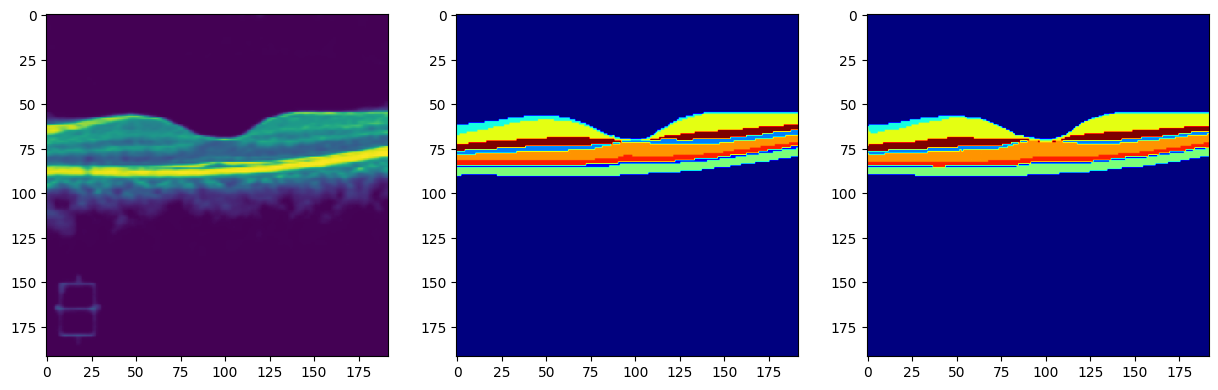

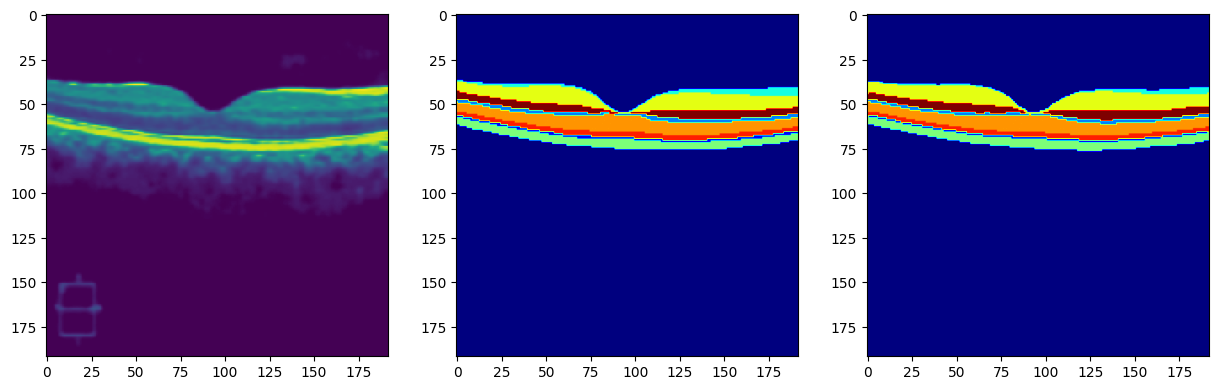

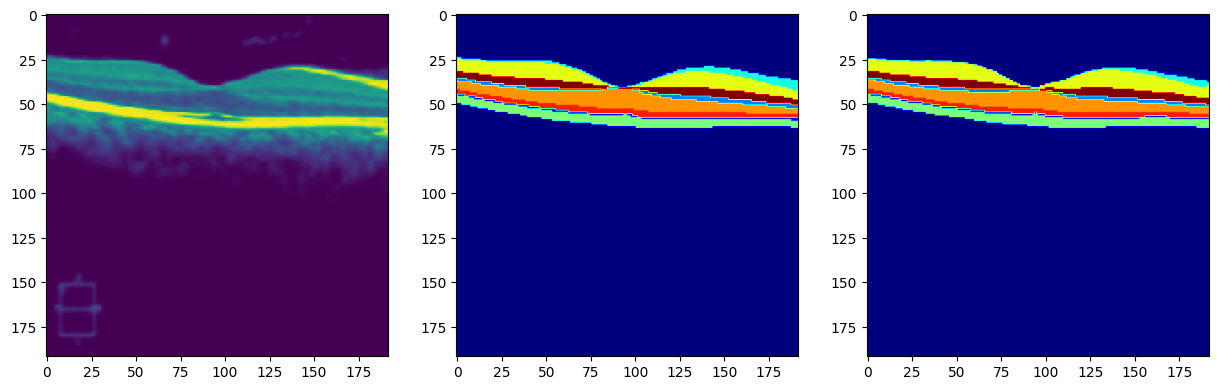

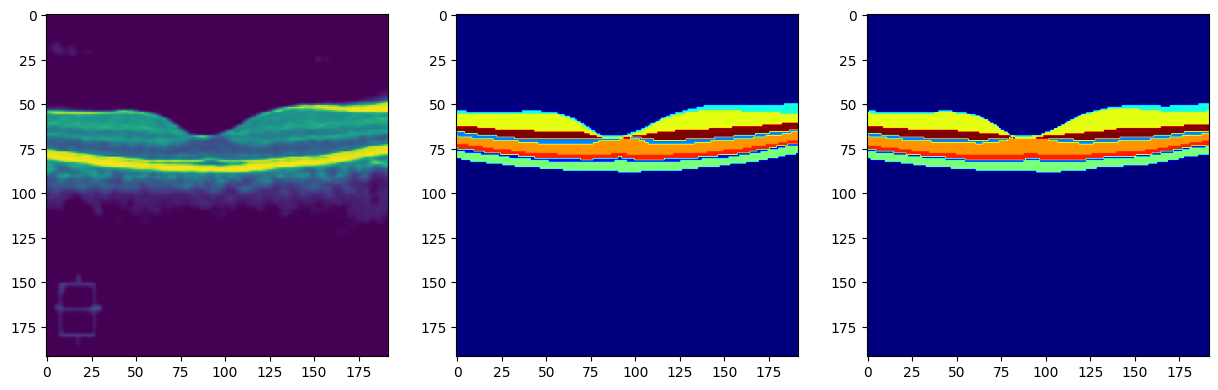

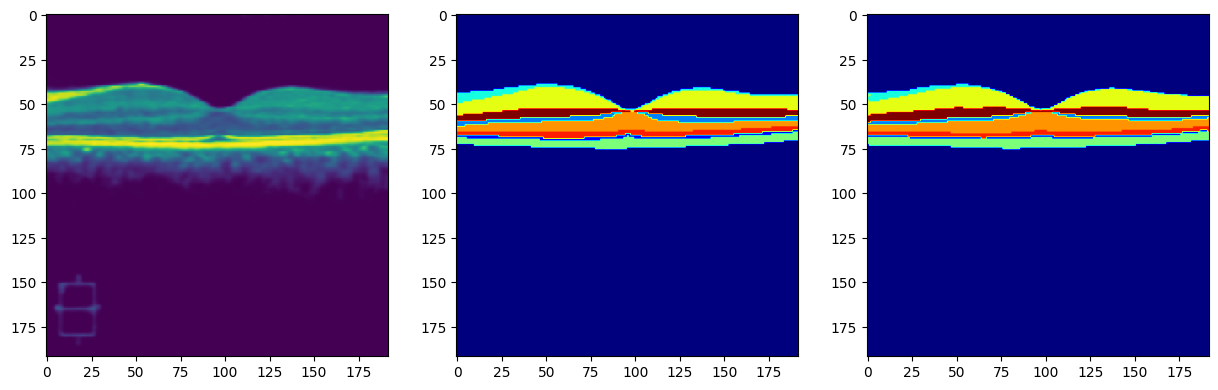

In [27]:
i=0
for img, org, msk in zip(imgs, original, pred):
#     print(org.shape,msk.shape)
    plt.figure(figsize=(15, 5))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.subplot(1,3,2)
    plt.imshow(org,cmap="jet")
    plt.subplot(1,3,2)
    plt.imshow(org,cmap="jet")
    plt.subplot(1,3,3)
    plt.imshow(msk,cmap="jet")
    plt.show()
    i+=1
    if i==5:
        break